In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from cvxpy import *
from multiprocessing import Pool

sns.set()
%matplotlib inline

### Exploring Lasso and Elastic Net in Linear Regression with Missing Data

We consider observations $y = Ax_0 + w$ where we observe $y, A_{*} = A \odot Z$ where $x \in \mathbb{R}^{n}, y \in \mathbb{R}^{m}, Z \in \{0,1\}^{m \times n}, A \in \mathbb{R}^{m \times n}$.  We consider a sparse $x_0$ with entries from $\{-1, 0, 1\}$, $A_{ij} \sim N(0,1/m)$, $Z_{ij} \sim \text{Bern}(p)$, $w \sim N(0,\sigma^2 I)$.

Specifically, we take $n=2000, m=1000, \sigma^2 = 0.05, p=0.8$.  We use cvxpy as a solver (note that all the programs run here are convex).

In [2]:
n = 2000
delta = 0.5
sigma2 = 0.05
num_iter = 100
lam = Parameter(sign="positive")
p = 0.8

m = int(np.ceil(delta*n))
x0 = ((2*np.random.uniform(0,1,n) > 0.5) - 1) * (np.random.uniform(0,1,n)>0.8)
A = np.random.normal(0,1,(m,n))/np.sqrt(m)
Z = np.random.binomial(1, p, A.shape)
A_star = A * Z
# A_tilde = A * (1 - Z)
y = A @ x0 + np.sqrt(sigma2)*np.random.randn(m)

mu = (1 - p) * (1 - np.linalg.norm(x0,0)/n)

### Naive LASSO with Missing Data
The following cell runs $\text{argmin}_{x}{||A_{*}x - y||_2^2 + \lambda||x||_1}$, where we sweep $\lambda$ from $0.01$ to $3$

In [31]:
### Missing LASSO Solution ###
x = Variable(n)
objective = Minimize(sum_squares(A_star@x - y) + lam*norm(x, 1))
p = Problem(objective)

# Assign a value to gamma and find the optimal x.
def get_x(lambda_value):
    lam.value = lambda_value
    result = p.solve()
    return x.value

lambdas = np.linspace(0.01, 3, 20)
# Serial computation.
x_values = [get_x(value) for value in lambdas]

mse_mlasso = []
for x_val in x_values:
    temp_val = np.array(x_val)
    mse_mlasso.append(np.mean((temp_val - x0)**2))

### Oracle LASSO
The following cell runs $\text{argmin}_{x}||Ax - y||_2^2 + \lambda ||x||_1$ with the same $\lambda$ parameters as above

In [32]:
### Full LASSO Solution ###
x = Variable(n)
objective = Minimize(sum_squares(A@x - y) + lam*norm(x, 1))
p = Problem(objective)

# Assign a value to gamma and find the optimal x.
def get_x(lambda_value):
    lam.value = lambda_value
    result = p.solve()
    return x.value

lambdas = np.linspace(0.01, 3, 20)
# Serial computation.
x_values = [get_x(value) for value in lambdas]

mse_flasso = []
for x_val in x_values:
    temp_val = np.array(x_val)
    mse_flasso.append(np.mean((temp_val - x0)**2))

### Elastic Net with Missing Data
Here, we run $\text{argmin}_{x}{||A_{*}x - y||_2^2 + (1 - p)(1 - \frac{||x_0||_{0}}{m}||x||_2^2 + \lambda||x||_1}$, sweeping the same values of $\lambda$.  The specific constant in front of the $\ell_2$ regularization comes from the fixed point of the AMP.  Note that it requires the sparsity of the solution as well as the missingness parameter which may not be available.

In [33]:
### Elastic Net Solution ###
x = Variable(n)
objective = Minimize(sum_squares(A_star@x - y) + lam*norm(x, 1) + mu * norm(x,2))
p = Problem(objective)

# Assign a value to gamma and find the optimal x.
def get_x(lambda_value):
    lam.value = lambda_value
    result = p.solve()
    return x.value

lambdas = np.linspace(0.01, 3, 20)
# Serial computation.
x_values = [get_x(value) for value in lambdas]

mse_enet = []
for x_val in x_values:
    temp_val = np.array(x_val)
    mse_enet.append(np.mean((temp_val - x0)**2))

(0, 1)

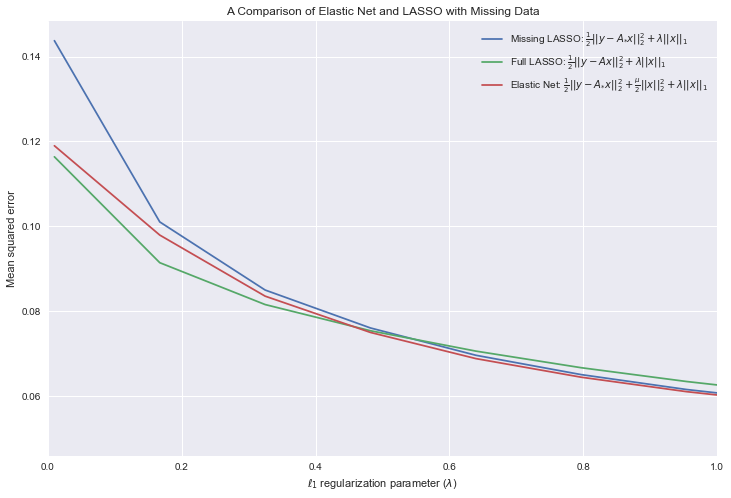

In [41]:
plt.figure(figsize=(12,8))
plt.plot(lambdas, mse_mlasso, label=r'Missing LASSO: $\frac{1}{2}||y - A_{*}x||_{2}^{2} + \lambda||x||_{1}$')
plt.plot(lambdas, mse_flasso, label=r'Full LASSO: $\frac{1}{2}||y - Ax||_{2}^{2} + \lambda||x||_{1}$')
plt.plot(lambdas, mse_enet, \
         label=r'Elastic Net: $\frac{1}{2}||y - A_{*}x||_{2}^{2} + \frac{\mu}{2}||x||_{2}^{2} + \lambda||x||_{1}$')
plt.legend()
plt.xlabel(r"$\ell_1$ regularization parameter ($\lambda$)")
plt.ylabel("Mean squared error")
plt.title("A Comparison of Elastic Net and LASSO with Missing Data")
plt.xlim(0,1)